In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    
    tensorflow.reset_default_graph()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()

7


def BuildModel_SegNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_SegNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [3]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [4]:
def BuildModel_UNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conc_1 = Concatenate()([conv_3_2, up_1])
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_2_2, up_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_1_2, up_3])
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

net_name = 'unet'
best_w_file = net_name + '_best.h5'
last_w_file = net_name + '_last.h5'

best_w = keras.callbacks.ModelCheckpoint(best_w_file,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint(last_w_file,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

weights = np.array([11.333580017089844, 80.10086822509766, 8.1307373046875, 0.434814453125]).astype(np.float32) / 100.0
weights = (np.sum(weights) - weights / np.sum(weights))
# print(weights)

def CreateModel():
    model = BuildModel_UNet()
    model.compile(
        optimizer=adam,
        metrics=['accuracy'], 
        loss=weighted_categorical_crossentropy(weights)
    )
    
    return model


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		10000
Number of files in Validation-set:	2000


img_df = data.train.image_paths
mask_df = data.train.masks_paths
batch_size = 26

index = 0
while index < 5:
    x_batch = []
    y_batch = []
    r_batch = []

    for i in range(batch_size):
        img_name = img_df[index]
        mask_name = mask_df[index]

#             print(index, img_name, mask_name)

        index = (index + 1) % len(img_df)

        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

#             img, mask

        img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
        mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

        height, width = mask.shape
        masks = np.zeros((height, width, 4))
        for i in range(masks.shape[2]):
            masks[:, :, i] = (mask == (i+1))

        #moving the channel:
        mask_train = np.moveaxis(masks,-1,1)

        x_batch += [img]
        y_batch.append(mask_train)
        r_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    r_batch = np.array(r_batch) / 255.

x_batch.shape,y_batch.shape,r_batch.shape

In [6]:
def read_image_with_mask(img_name, mask_name):
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#     img, mask
            
    img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
    mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

    height, width = mask.shape
    masks = np.zeros((height, width, 4))
    for i in range(masks.shape[2]):
        masks[:, :, i] = (mask == (i + 1))
            
#     masks = np.moveaxis(masks,-1,1)

    return img / 255., masks / 1.

def prepare_image_and_mask_for_prediction(img_name, mask_name):
    img, masks = read_image_with_mask(img_name, mask_name)
    return np.array([img]), np.array([masks])

def keras_generator(img_df, mask_df, batch_size, iteration):
    index = iteration * batch_size
    print('keras_generator.index = {}'.format(index))
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img, masks = read_image_with_mask(img_name, mask_name)
            
            x_batch += [img]
            y_batch.append(masks)

        
#         print(x_batch.shape,y_batch.shape)

        yield np.array(x_batch), np.array(y_batch)

In [7]:
def append_keras_history_to_all_history(common_history, keras_history):
    if len(common_history) == 0:
        common_history = {
            'val_loss': [],
            'val_acc': [],
            'loss': [],
            'acc': []
        }
    
    for key in keras_history.history.keys():
        common_history[key].append(keras_history.history[key])
    
    return all_history

In [8]:
from keras.models import load_model

full_history = {}

batch_size = 16

iterations = 8
epochs_per_iteration = 5

model_stage_file = 'model_weights_stage.h5'

for iteration in range(iterations):
    print('Iteration {}...'.format(iteration))
    
    model = CreateModel()
    
    if (os.path.exists(model_stage_file)):
        model = load_model(model_stage_file, custom_objects = {'loss': weighted_categorical_crossentropy(weights)})
    
    history = model.fit_generator(
                keras_generator(data.train.image_paths, data.train.masks_paths, batch_size, iteration),
                steps_per_epoch = 300,
                epochs = epochs_per_iteration,
                verbose = 1,
                callbacks = callbacks,
                validation_data = keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size, iteration),
                validation_steps = 60,
                class_weight = None,
                max_queue_size = 10,
                workers = 1,
                use_multiprocessing = False,
                shuffle = True,
                initial_epoch = 0
    )
    
    model.save(model_stage_file)

    common_history = append_keras_history_to_all_history(common_history, history)

    del history
    del model
#     gc.collect()
    reset_keras()


Iteration 0...
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
keras_generator.index = 0
keras_generator.index = 0
300/300 [==============================] - 93s 310ms/step - loss: 0.2794 - acc: 0.8227 - val_loss: 0.1552 - val_acc: 0.8993
Epoch 2/5
300/300 [==============================] - 88s 292ms/step - loss: 0.1332 - acc: 0.8794 - val_loss: 0.1302 - val_acc: 0.8996
Epoch 3/5
300/300 [==============================] - 88s 292ms/step - loss: 0.1145 - acc: 0.8915 - val_loss: 0.0998 - val_acc: 0.9027
Epoch 4/5
300/300 [==============================] - 88s 294ms/step - loss: 0.1007 - acc: 0.9022 - val_loss: 0.0933 - val_acc: 0.9067
Epoch 5/5
300/300 [==============================] - 89s 295ms/step - loss: 0.0943 - acc: 0.9055 - val_loss: 0.0944 - val_acc: 0.9150
133
Iteration 1...
Epoch 1/5
keras_generator.index = 16keras_generator.index = 16

300/300 [==============================] - 91s 302ms/step - loss: 0.0888 - acc: 0.9092 - val_loss: 0.0817 - val_acc: 0.9084
Epoch 2/

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


405
Iteration 2...
Epoch 1/5
keras_generator.index = 32
keras_generator.index = 32
300/300 [==============================] - 89s 295ms/step - loss: 0.0715 - acc: 0.9221 - val_loss: 0.0678 - val_acc: 0.9230
Epoch 2/5
300/300 [==============================] - 89s 295ms/step - loss: 0.0689 - acc: 0.9243 - val_loss: 0.0667 - val_acc: 0.9354
Epoch 3/5
300/300 [==============================] - 89s 296ms/step - loss: 0.0666 - acc: 0.9264 - val_loss: 0.0640 - val_acc: 0.9378
Epoch 4/5
300/300 [==============================] - 89s 296ms/step - loss: 0.0639 - acc: 0.9292 - val_loss: 0.0605 - val_acc: 0.9321
Epoch 5/5
300/300 [==============================] - 89s 295ms/step - loss: 0.0612 - acc: 0.9316 - val_loss: 0.0582 - val_acc: 0.9317


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.st

126874
Iteration 3...
Epoch 1/5
keras_generator.index = 48
keras_generator.index = 48
300/300 [==============================] - 88s 295ms/step - loss: 0.0584 - acc: 0.9343 - val_loss: 0.0540 - val_acc: 0.9388
Epoch 2/5
300/300 [==============================] - 88s 292ms/step - loss: 0.0571 - acc: 0.9357 - val_loss: 0.0560 - val_acc: 0.9387
Epoch 3/5
300/300 [==============================] - 88s 292ms/step - loss: 0.0531 - acc: 0.9395 - val_loss: 0.0527 - val_acc: 0.9464
Epoch 4/5
300/300 [==============================] - 88s 293ms/step - loss: 0.0525 - acc: 0.9405 - val_loss: 0.0485 - val_acc: 0.9422
Epoch 5/5
300/300 [==============================] - 88s 292ms/step - loss: 0.0483 - acc: 0.9447 - val_loss: 0.0467 - val_acc: 0.9494


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.st

126874
Iteration 4...
Epoch 1/5
keras_generator.index = 64
keras_generator.index = 64
300/300 [==============================] - 89s 296ms/step - loss: 0.0465 - acc: 0.9466 - val_loss: 0.0484 - val_acc: 0.9371
Epoch 2/5
300/300 [==============================] - 90s 301ms/step - loss: 0.0458 - acc: 0.9477 - val_loss: 0.0439 - val_acc: 0.9492
Epoch 3/5
300/300 [==============================] - 90s 301ms/step - loss: 0.0420 - acc: 0.9514 - val_loss: 0.0409 - val_acc: 0.9561
Epoch 4/5
300/300 [==============================] - 90s 301ms/step - loss: 0.0418 - acc: 0.9520 - val_loss: 0.0392 - val_acc: 0.9556
Epoch 5/5
300/300 [==============================] - 91s 302ms/step - loss: 0.0385 - acc: 0.9553 - val_loss: 0.0395 - val_acc: 0.9607


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.st

126874
Iteration 5...
Epoch 1/5
keras_generator.index = 80
keras_generator.index = 80
300/300 [==============================] - 89s 297ms/step - loss: 0.0365 - acc: 0.9574 - val_loss: 0.0377 - val_acc: 0.9608
Epoch 2/5
300/300 [==============================] - 97s 322ms/step - loss: 0.0379 - acc: 0.9563 - val_loss: 0.0378 - val_acc: 0.9570
Epoch 3/5
300/300 [==============================] - 90s 300ms/step - loss: 0.0338 - acc: 0.9604 - val_loss: 0.0346 - val_acc: 0.9634
Epoch 4/5
300/300 [==============================] - 90s 298ms/step - loss: 0.0374 - acc: 0.9567 - val_loss: 0.0325 - val_acc: 0.9619
Epoch 5/5
300/300 [==============================] - 91s 302ms/step - loss: 0.0320 - acc: 0.9623 - val_loss: 0.0322 - val_acc: 0.9637


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.st

126874
Iteration 6...
Epoch 1/5
keras_generator.index = 96keras_generator.index = 96

300/300 [==============================] - 89s 296ms/step - loss: 0.0299 - acc: 0.9647 - val_loss: 0.0363 - val_acc: 0.9567
Epoch 2/5
300/300 [==============================] - 89s 295ms/step - loss: 0.0339 - acc: 0.9608 - val_loss: 0.0310 - val_acc: 0.9665
Epoch 3/5
300/300 [==============================] - 90s 300ms/step - loss: 0.0284 - acc: 0.9663 - val_loss: 0.0301 - val_acc: 0.9613
Epoch 4/5
300/300 [==============================] - 88s 292ms/step - loss: 0.0306 - acc: 0.9642 - val_loss: 0.0283 - val_acc: 0.9680
Epoch 5/5
300/300 [==============================] - 88s 294ms/step - loss: 0.0267 - acc: 0.9682 - val_loss: 0.0290 - val_acc: 0.9678


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.st

126874
Iteration 7...
Epoch 1/5
keras_generator.index = 112keras_generator.index = 112

300/300 [==============================] - 89s 296ms/step - loss: 0.0256 - acc: 0.9694 - val_loss: 0.0302 - val_acc: 0.9616
Epoch 2/5
300/300 [==============================] - 88s 292ms/step - loss: 0.0279 - acc: 0.9671 - val_loss: 0.0273 - val_acc: 0.9686
Epoch 3/5
300/300 [==============================] - 90s 299ms/step - loss: 0.0247 - acc: 0.9705 - val_loss: 0.0285 - val_acc: 0.9617
Epoch 4/5
300/300 [==============================] - 88s 294ms/step - loss: 0.0267 - acc: 0.9685 - val_loss: 0.0261 - val_acc: 0.9735
Epoch 5/5
300/300 [==============================] - 87s 291ms/step - loss: 0.0235 - acc: 0.9718 - val_loss: 0.0265 - val_acc: 0.9695
126874


Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f6cd76d8488>
Traceback (most recent call last):
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ganchenkovv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.st

In [10]:
all_history

{}

In [9]:
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# list all data in history
print(all_history.keys())
# summarize history for accuracy
plt.plot(all_history['acc'])
plt.plot(all_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(all_history['loss'])
plt.plot(all_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys([])


KeyError: 'acc'

from keras.models import load_model

model1 = BuildModel_SegNet()
model1.load_weights('unet_best.h5')
# model1 = load_model('unet_best.h5')

In [11]:
from keras.models import load_model

# model1 = load_model('segnet_best.h5')
model1 = load_model(best_w_file, custom_objects={'loss': weighted_categorical_crossentropy(weights)})

In [12]:
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, 16, 0):
    break

keras_generator.index = 0


In [13]:
pred = model1.predict(x)

pred[:,:,:,2] *= 2

In [14]:
def getClassesMap(pred):
    res = np.zeros((pred.shape[0], pred.shape[1]), np.uint8)
    for r in range(pred.shape[0]):
        for c in range(pred.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            res[r,c] = pred_class_index
    res.shape
    return res

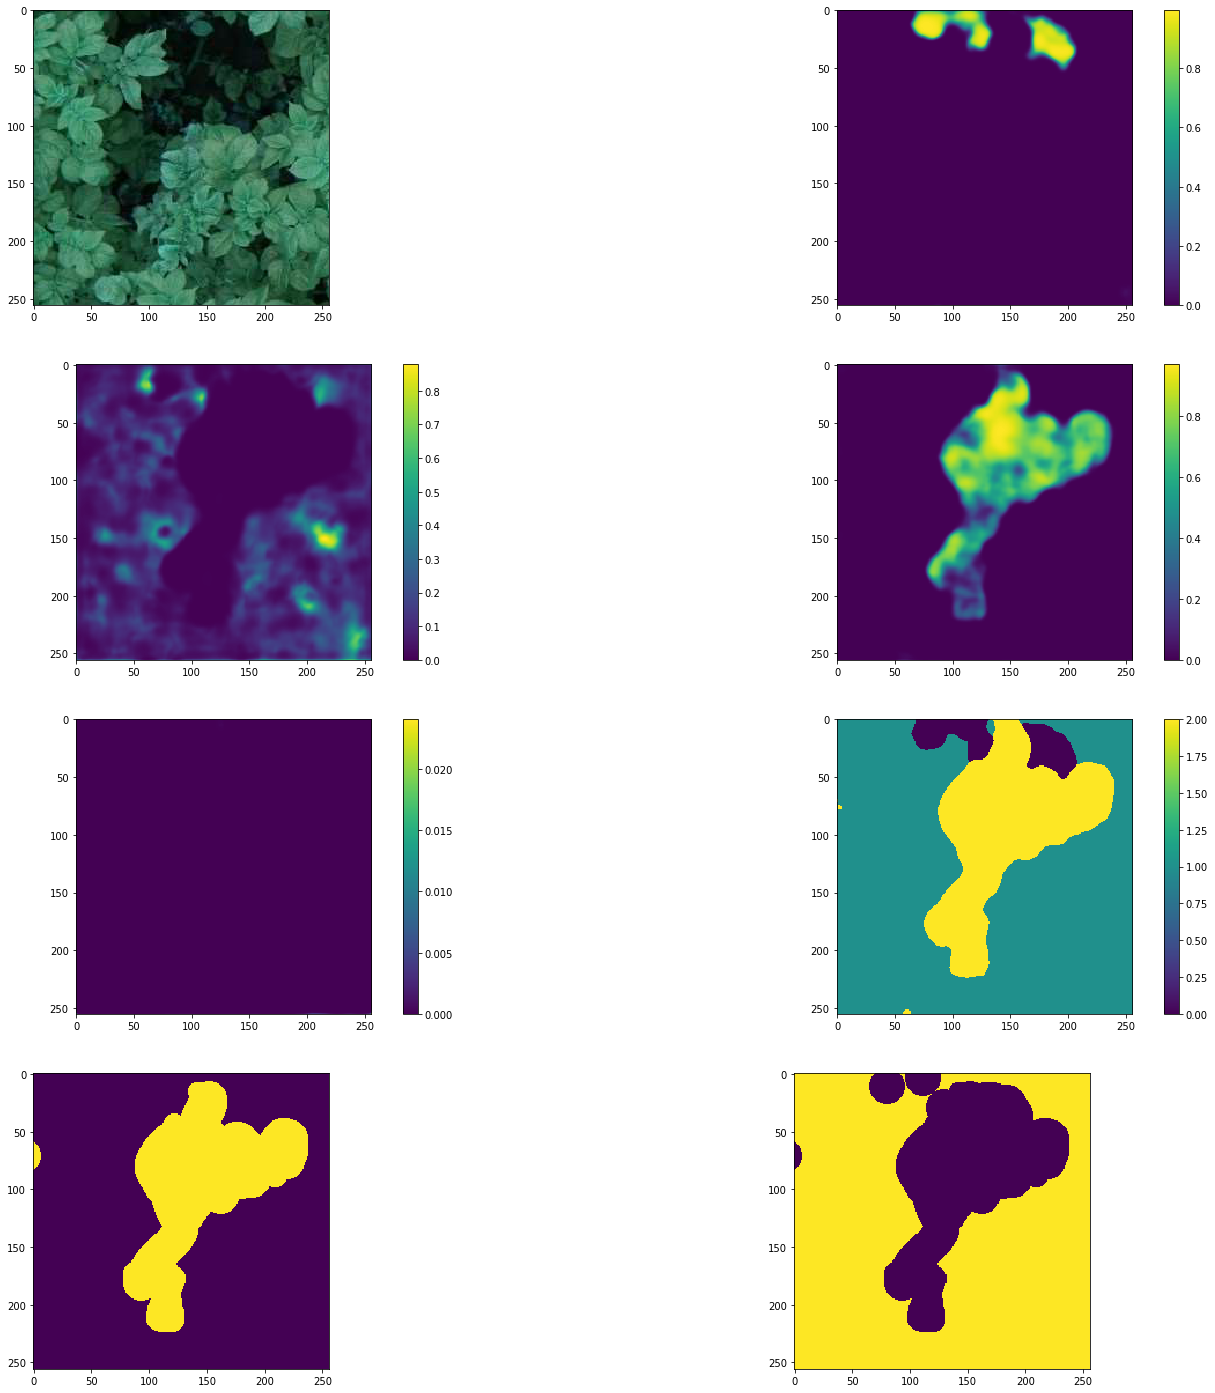

In [15]:
sample_index = 11
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
# im_2_1 = axes[2][1].imshow(keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).astype(np.float32))
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
# im_2_1 = axes[2][1].imshow(pred[sample_index, 20:40, 0:5, 0])
im_3_0 = axes[3][0].imshow(y[sample_index, ..., 2])
im_3_1 = axes[3][1].imshow(y[sample_index, ..., 1])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

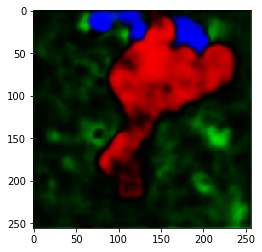

In [16]:
image = np.zeros((pred.shape[1],pred.shape[2], 3)).astype(np.float32)
image[:,:,0] = pred[sample_index, ..., 2]
image[:,:,1] = pred[sample_index, ..., 1]
image[:,:,2] = pred[sample_index, ..., 0]

image = (image * 255).astype(np.uint8)
plt.imshow(image)

In [17]:
def CountErrors(y, pred):
    ok_cnt = 0
    required = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
    }
    valid = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    errors = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    
    for r in range(y.shape[0]):
        for c in range(y.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            real_class_index = np.argmax(y[r,c,:])
            required[real_class_index] += 1
            if pred_class_index not in [0,1,2,3] or real_class_index not in [0,1,2,3]:
                print(r,c,pred_class_index, real_class_index)
                continue
#             print(r,c,pred_class_index, real_class_index)
            if pred_class_index == real_class_index:
                ok_cnt = ok_cnt + 1
                valid[real_class_index][pred_class_index] += 1
            else:
                errors[real_class_index][pred_class_index] += 1
    return ok_cnt, required, valid, errors

In [18]:
CountErrors(y[sample_index], pred[sample_index]) 

(64357,
 {0: 2866, 1: 47520, 2: 15150, 3: 0},
 {0: [2815, 0, 0, 0],
  1: [0, 46566, 0, 0],
  2: [0, 0, 14976, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 27, 24, 0], 1: [258, 0, 696, 0], 2: [33, 141, 0, 0], 3: [0, 0, 0, 0]})

In [19]:
sample_index = 2

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [20]:
ok_cnt, required, valid, errors

(63587,
 {0: 8775, 1: 55229, 2: 1532, 3: 0},
 {0: [8387, 0, 0, 0],
  1: [0, 53740, 0, 0],
  2: [0, 0, 1460, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 346, 42, 0], 1: [1393, 0, 96, 0], 2: [10, 62, 0, 0], 3: [0, 0, 0, 0]})

In [21]:
sample_index = 5

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])   

In [22]:
ok_cnt, required, valid, errors

(64171,
 {0: 5451, 1: 58741, 2: 310, 3: 1034},
 {0: [5139, 0, 0, 0],
  1: [0, 57766, 0, 0],
  2: [0, 0, 266, 0],
  3: [0, 0, 0, 1000]},
 {0: [0, 311, 1, 0], 1: [801, 0, 75, 99], 2: [41, 3, 0, 0], 3: [0, 34, 0, 0]})

### Image by image segmentation

In [ ]:
img_name = './validation/sample_4.png'
mask_name = './validation/sample_4_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

In [ ]:
pred = model1.predict(x)

for index in range(4):
    img = pred[0, ..., index] / np.max(pred[0, ..., index])
    img *= 255.0
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.imwrite('unet_{}.png'.format(index), img)
    
img = getClassesMap(pred[0]).astype(np.float32)
img = img / np.max(img)
img *= 255.0
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite('unet_classes.png', img)

img = y[0].astype(np.float32)
img = y[0, ..., 0] * 0.0001 + y[0, ..., 1] * 1 + y[0, ..., 2] * 2 + y[0, ..., 3] * 3
img = img / np.max(img)
img *= 255.0
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite('unet_gt.png', img)

In [ ]:
plt.imshow(x[0])

In [ ]:
plt.imshow(pred[0, ..., 2])

In [ ]:
plt.imshow(y[0, ..., 2])

In [ ]:
plt.imshow(getClassesMap(pred[0]))

In [ ]:
sum(sum(getClassesMap(pred)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0,0].imshow(x[0])
im_0_1 = axes[0][1].imshow(pred[0, ..., 0])

plt.colorbar(im_0_1, ax=axes[0,1])

In [ ]:
pred = model1.predict(x)

pred[:,:,:,2] *= 2

In [ ]:
ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 

In [ ]:
ok_cnt, required, valid, errors

### Estimate accuracy for validation set

In [23]:
all_ok_cnt = 0
all_required = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in tqdm(range(len(data.valid.image_paths))):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
#     pred[:,:,:,2] *= 2
    
    ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_required[j] = all_required[j] + required[j]
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_required[j] /= scale
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [24]:
all_ok_cnt, all_required, all_valid, all_errors

(97.31814575195312,
 {0: 13.904063415527343,
  1: 77.32612228393555,
  2: 8.216709899902344,
  3: 0.5531044006347656},
 {0: [13.484489440917969, 0.0, 0.0, 0.0],
  1: [0.0, 75.29117050170899, 0.0, 0.0],
  2: [0.0, 0.0, 8.012348937988282, 0.0],
  3: [0.0, 0.0, 0.0, 0.5301368713378907]},
 {0: [0.0, 0.32603912353515624, 0.08222122192382812, 0.011313629150390626],
  1: [1.2406021118164063, 0.0, 0.7437400817871094, 0.050609588623046875],
  2: [0.049852752685546876, 0.15450820922851563, 0.0, 0.0],
  3: [0.013314056396484374, 0.009651947021484374, 1.52587890625e-06, 0.0]})

In [29]:
confusion_matrix = np.zeros([4,4])
for x in range(4):
    confusion_matrix[x,x] = all_valid[x][x] / all_required[x]

for real_class in range(4):
    for predicted_class in range(4):
        if real_class == predicted_class:
            continue
        confusion_matrix[predicted_class,real_class] = all_errors[real_class][predicted_class]

precision = np.zeros([4])
for i in range(4):
    precision[i] = confusion_matrix[i,i] / sum(confusion_matrix[i,:])
    
recall = np.zeros([4])
for i in range(4):
    recall[i] = confusion_matrix[i,i] / sum(confusion_matrix[:,i])
        
def CalcF(precisionV, recallV):
    return 2 * precisionV * recallV / (precisionV + recallV)

F = [ CalcF(precisionV, recallV) for precisionV, recallV in zip(precision, recall) ]
F = np.array(F)

confusion_matrix, precision, recall, F
np.set_printoptions(precision=2)
np.set_printoptions(formatter={"float_kind": lambda x: "%0.2f" % x})

print("confusion_matrix = \n{}".format(confusion_matrix))
print("precision = {}".format(precision))
print("recall = {}".format(recall))
print("F = {}".format(F))

confusion_matrix = 
[[0.97 1.24 0.05 0.01]
 [0.33 0.97 0.15 0.01]
 [0.08 0.74 0.98 0.00]
 [0.01 0.05 0.00 0.96]]
precision = [0.43 0.67 0.54 0.94]
recall = [0.70 0.32 0.83 0.98]
F = [0.53 0.44 0.65 0.96]
